# **USECASE: Building a disease-disease similairty netwrok**

* DBRetina is an efficent tool for  building a similarity network for a set of items by pairwaise calcuation of their shared features using a linear-time algorithm.
* [DisGeNET](https://www.disgenet.org/) has one of the largest collections of genes associated to human diseases.
* In this tutorial, we will use DBRetina to build a disease-disease similairty netwrok based on the shared number of genes asscoiated with them in the DisGeNET database

In [1]:
%%bash
## Download the most recent version of disease gene associations from DisGeNET
if [ ! -f all_gene_disease_associations.tsv ];then
  wget --quiet http://www.disgenet.org/static/disgenet_ap1/files/downloads/all_gene_disease_associations.tsv.gz
  gunzip all_gene_disease_associations.tsv.gz
else echo "all_gene_disease_associations.tsv file exists in the disgenet DB";fi

In [2]:
%%bash
head -n3 all_gene_disease_associations.tsv | tr '\t' ',' | sed 's/ //g'
## Here are some quaility matrices
# Score: estimate for the curation and size of evidence 
# DSI (Disease Specificity Index): Some genes are associated wiht multiple diseases (e.g. TNF) while others are more specific
# DPI (Disease Pleiotropy Index): similar but consider the disease similarity based on MeSH classes

geneId,geneSymbol,DSI,DPI,diseaseId,diseaseName,diseaseType,diseaseClass,diseaseSemanticType,score,EI,YearInitial,YearFinal,NofPmids,NofSnps,source
1,A1BG,0.7,0.538,C0001418,Adenocarcinoma,group,C04,NeoplasticProcess,0.01,1,2008,2008,1,0,LHGDN
1,A1BG,0.7,0.538,C0002736,AmyotrophicLateralSclerosis,disease,C18;C10,DiseaseorSyndrome,0.01,1,2008,2008,1,0,BEFREE


In [4]:
%%bash
## transform the data table into the DBRetina format
## DBRetina expects 2 files. Both are tab-separated files with two columns. Files must have header lines
## 1) Associations file: The 1st column for "items" and the 2nd for their asscoiated "features".
## 2) Super-association file: The 1st column for "items" and the 2nd for their "aliases". You can use this column to update the item name or if you want to pool multiple items together as one super item otherwise the 2nd column should be a copy of the 1st column
## In addition, we will filter the input list to keep trusted disease-gene associations only (DisGeNET score > 0.3)
cat all_gene_disease_associations.tsv | sed -e 's/^[ \t]*//' | awk 'BEGIN{FS=OFS="\t";}{if($10>0.3)print $6,$2}' > disgenet.asc
tail -n+2 disgenet.asc | awk 'BEGIN{FS=OFS="\t";}{print $1,$1}' | sort | uniq > disgenet.names

In [5]:
%%bash
## Let us explore the format of the prepared filed
echo "DisGeNET input file"
wc -l all_gene_disease_associations.tsv
echo "==================="

echo "Associations file"
wc -l disgenet.asc
echo "-------------------"
head -n3 disgenet.asc
echo "==================="

echo "Super-associations file"
wc -l disgenet.names
echo "-------------------"
head -n3 disgenet.names

DisGeNET input file
1134943 all_gene_disease_associations.tsv
Associations file
33012 disgenet.asc
-------------------
diseaseName	geneSymbol
Alzheimer's Disease	A2M
Malignant tumor of colon	A2M
Super-associations file
8155 disgenet.names
-------------------
11-Beta-hydroxylase deficiency	11-Beta-hydroxylase deficiency
12q14 microdeletion syndrome	12q14 microdeletion syndrome
17,20-Lyase Deficiency, Isolated	17,20-Lyase Deficiency, Isolated


In [ ]:
%%bash
## Now we can run DBRetina
DBRetina index --asc disgenet.asc --names disgenet.names --output disgenetDBR
DBRetina pairwise --index-prefix disgenetDBR

# The output of DBRetina pairwise includes:
# 1) A table of pairwise combinations "${kPro_index}_DBRetina_pairwise.tsv". The table show different distance measures
# 2) A JSON stat file and histograms to allow exploring the distributions of these distance measures 

In [7]:
%%bash
# Have a look on the output pairwise file
head disgenetDBR_DBRetina_pairwise.tsv

#nodes:8155
#command: DBRetina index --asc /home/jovyan/disgenet.asc --names /home/jovyan/disgenet.names --output disgenetDBR
#command: DBRetina pairwise --index-prefix disgenetDBR
group_1_ID	group_2_ID	group_1_name	group_2_name	shared_features	min_containment	avg_containment	max_containment	ochiai	jaccard
3569	3672	major depressive disorder	toxic shock syndrome	1	0.4	25.2	50.0	4.6	0.4
4366	5100	bipolar disorder	hemophilia a	1	0.2	25.1	50.0	3.5	0.2
2861	4500	neuroblastoma	giant cell glioblastoma	1	2.3	8.3	14.3	5.7	2.0
2856	4816	adult type dermatomyositis	dermatomyositis, childhood type	3	50.0	75.0	100.0	70.7	50.0
696	6570	diabetes mellitus, insulin-dependent	hyperglycemia	4	9.8	13.6	17.4	13.0	6.7
4571	7616	malignant tumor of colon	hepatoblastoma	5	4.4	33.5	62.5	16.6	4.3


In [8]:
%%bash
# How many pairwise combinations did we do?
echo "The number of pairwise combinations =" $(wc -l disgenetDBR_DBRetina_pairwise.tsv | cut -d" " -f1)

The number of pairwise combinations = 165827


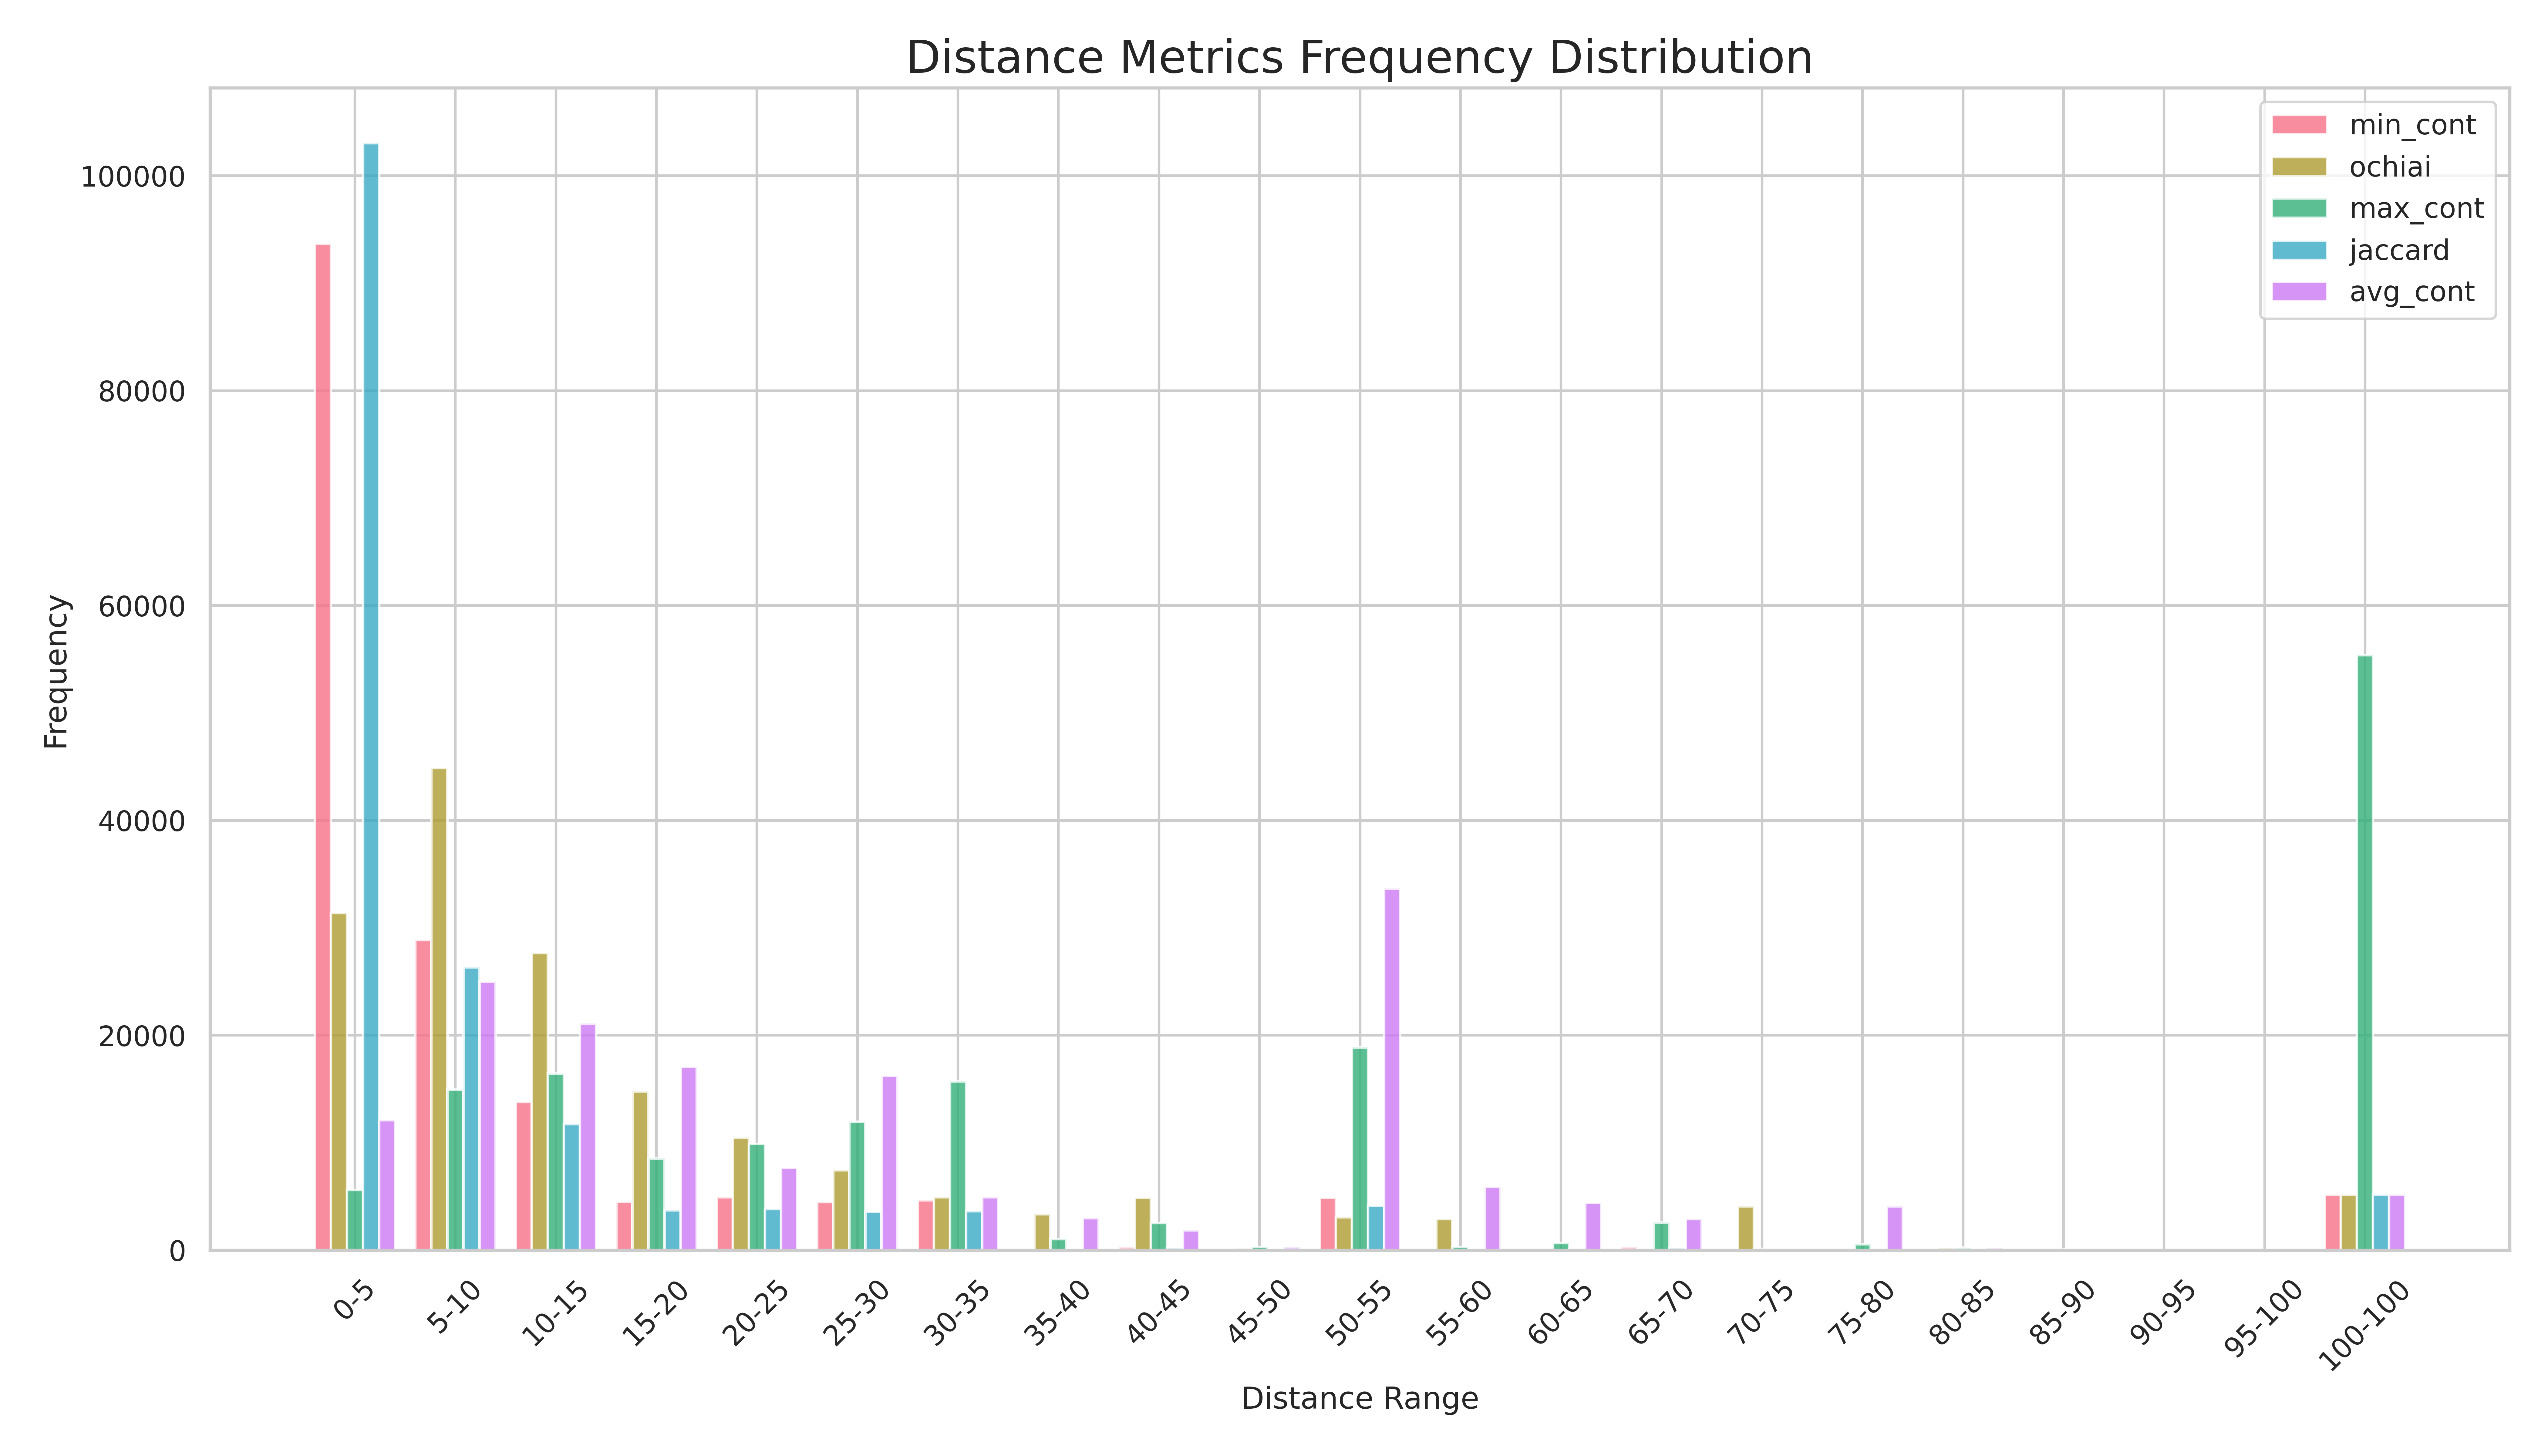

In [9]:
# Now, let us have a look on the distance metrics histogram
from IPython.display import Image
display(Image(filename='disgenetDBR_DBRetina_distance_metrics_plot_linear.png'))

In [10]:
%%bash
DBRetina cluster --pairwise disgenetDBR_DBRetina_pairwise.tsv --dist-type min_cont --cutoff 50 -o min_cont_50

## DBRetina cluster uses graph partitioning approach to recognize weakly connected componenets using one of the measure distance metrics
## To increase the partitioning of the graph, adding a cutoff will filter the low pairwise similarities on the fly and thus increase the number of clusters. 
## Clustering produces a cluster file as well as a histogram and a bubble plot for the cluster sizes.

[INFO] Loading TSV pairwise file
[INFO] Building the main graph...


[i] constructing graph


[INFO] Clustering...
[INFO] writing min_cont_50_clusters.tsv
[INFO] plotting cluster sizes histogram and bubble plot
[INFO] Total number of clustered supergroups: 5132
[INFO] number of clusters: 1216


In [11]:
%%bash
# Let us have a look on the cluster file
head min_cont_50_clusters.tsv

#nodes:8155
#command: DBRetina index --asc /home/jovyan/disgenet.asc --names /home/jovyan/disgenet.names --output disgenetDBR
#command: DBRetina pairwise --index-prefix disgenetDBR
#command: DBRetina cluster --pairwise /home/jovyan/disgenetDBR_DBRetina_pairwise.tsv --dist-type min_cont --cutoff 50 -o /home/jovyan/min_cont_50
cluster_id	cluster_size	cluster_members
1	5	nephropathic cystinosis|cystinosis, benign, nonnephropathic|cystinosis, atypical nephropathic (disorder)|cystinosis|juvenile nephropathic cystinosis (disorder)
2	310	enchondroma|malignant neoplasm of adrenal cortex|glioma susceptibility 2|salivary gland neoplasms|adenocarcinoma of colon|balkan nephropathy|endometrial stromal sarcoma, high grade|genitourinary cancer|squamous cell carcinoma of mouth|carcinoma, cribriform|erdheim-chester disease|craniofacial dysostosis|carcinoma, granular cell|anaplastic oligodendroglioma|robinow sorauf syndrome|diffuse astrocytoma|ameloblastoma|adrenocortical carcinoma, hereditary|desmoid d

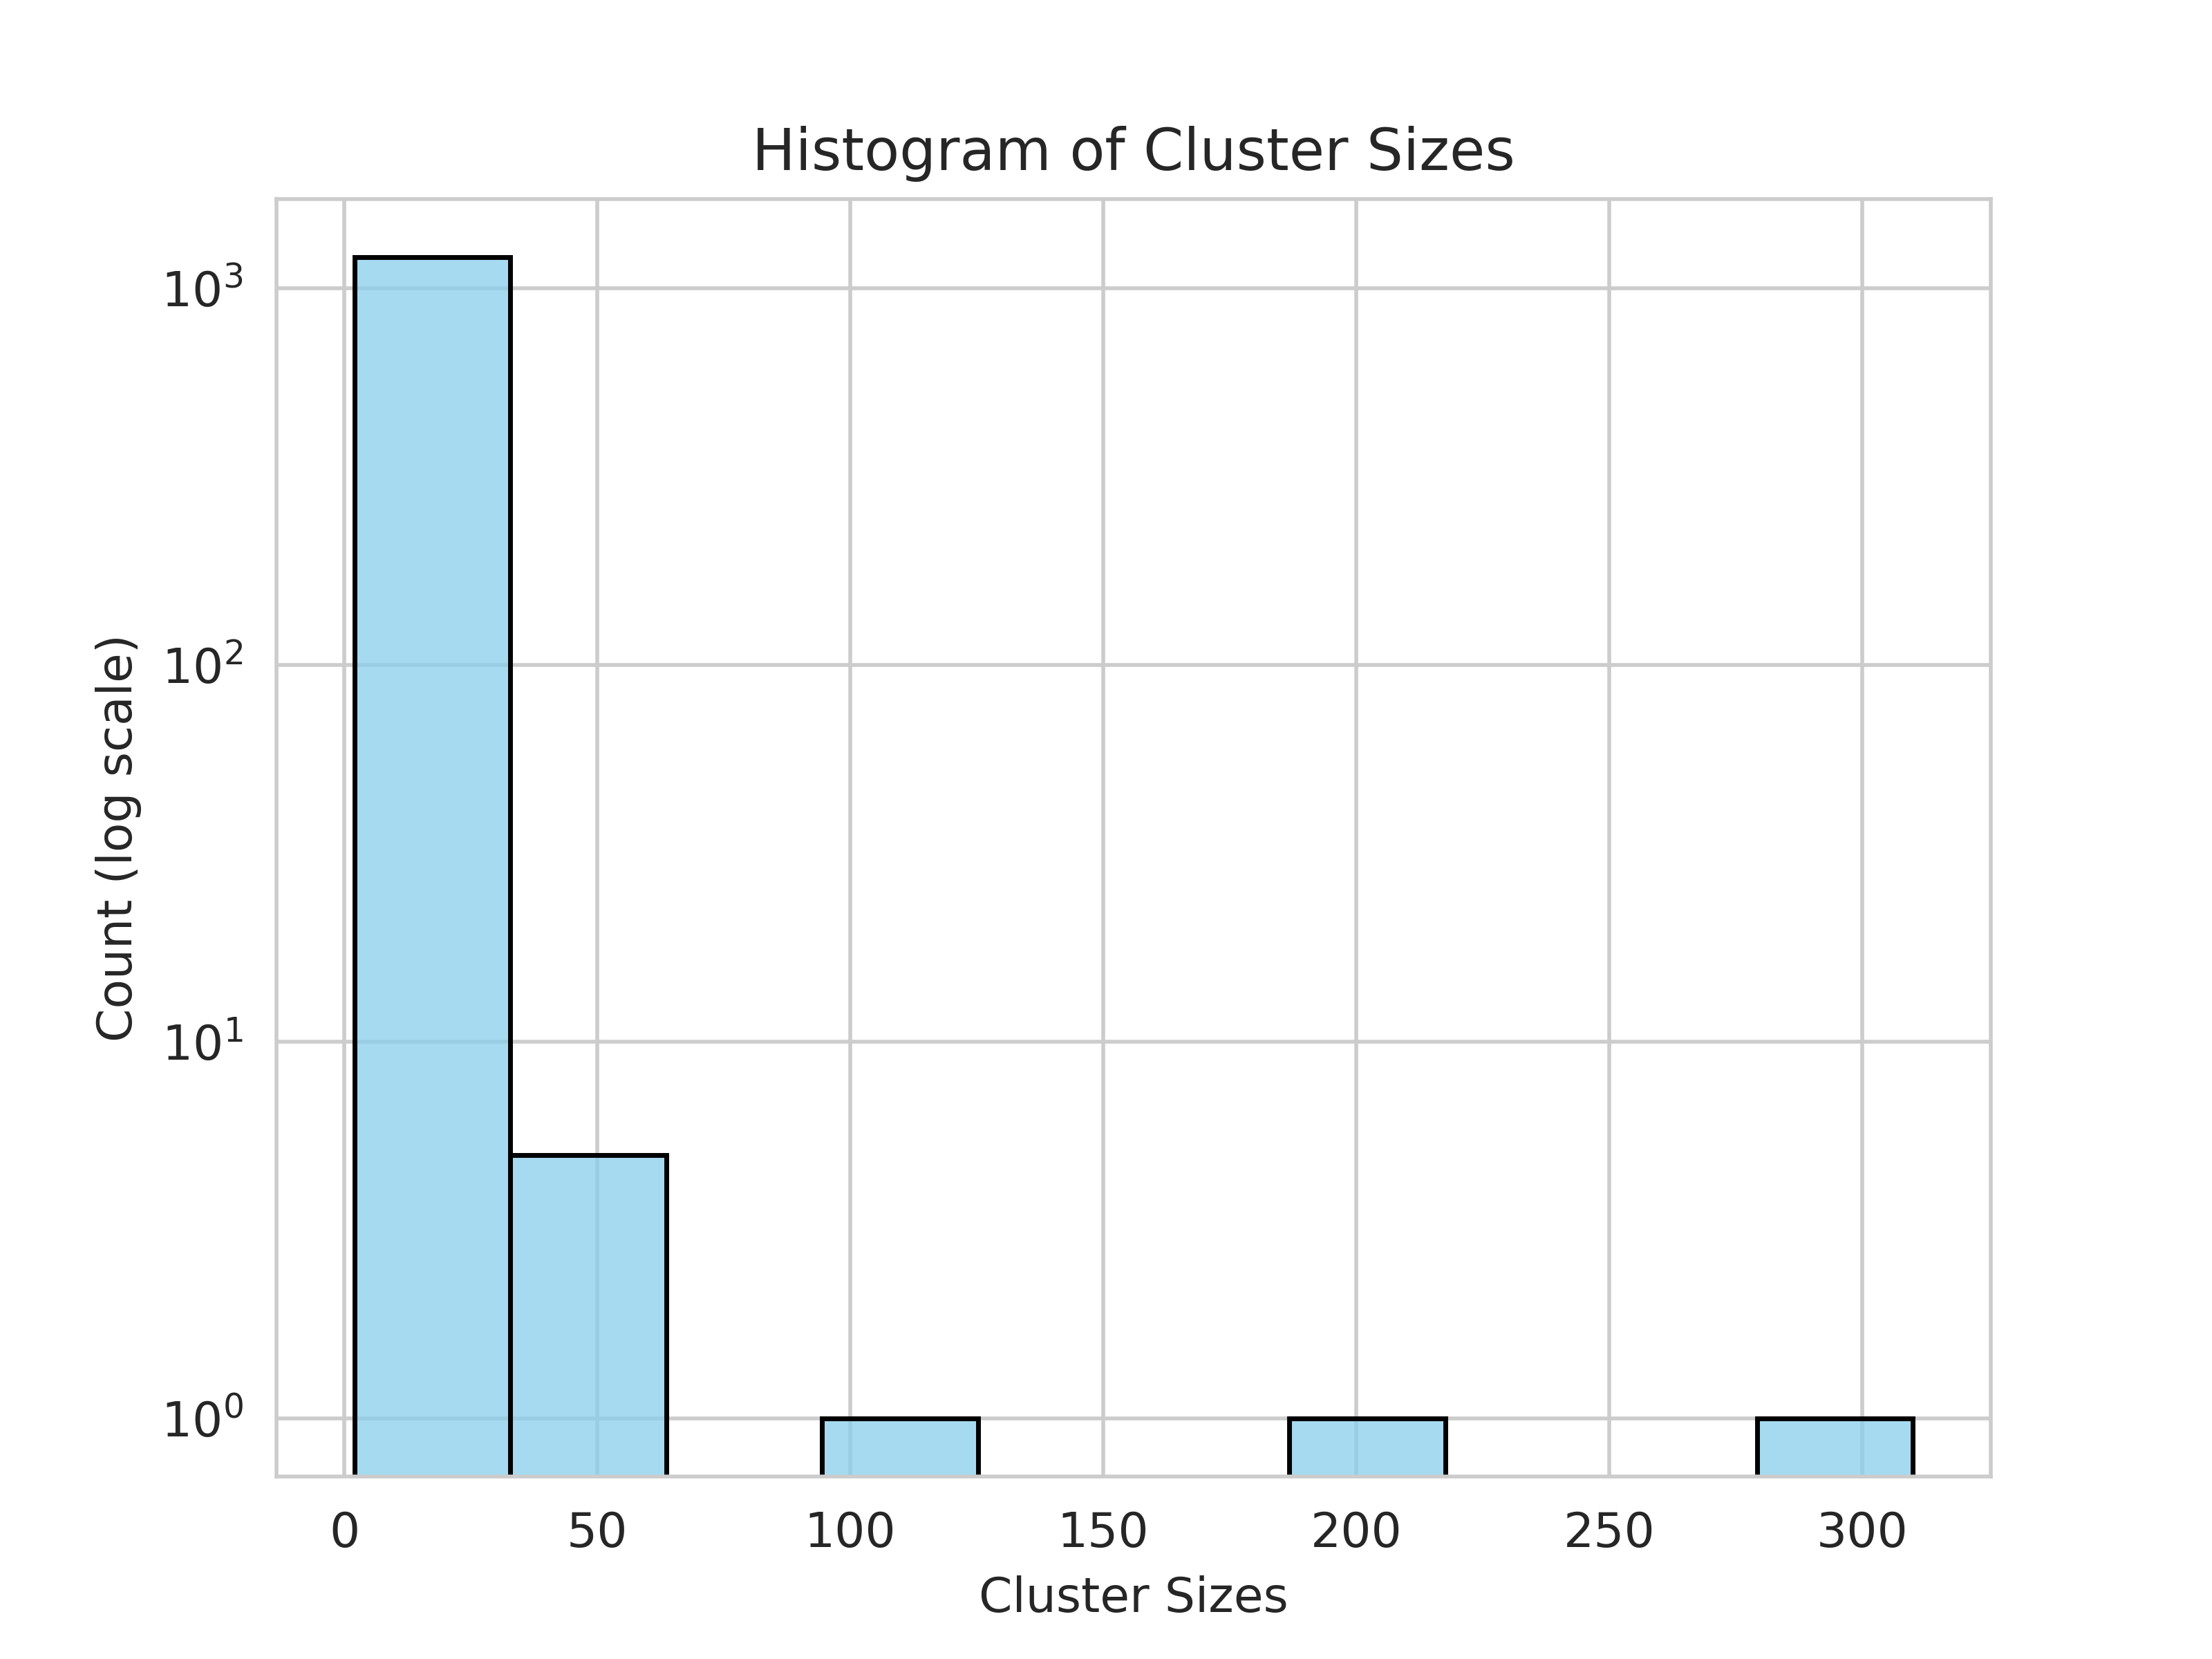

In [12]:
# and here is the histogram
display(Image(filename='min_cont_50_clusters_histogram.png'))

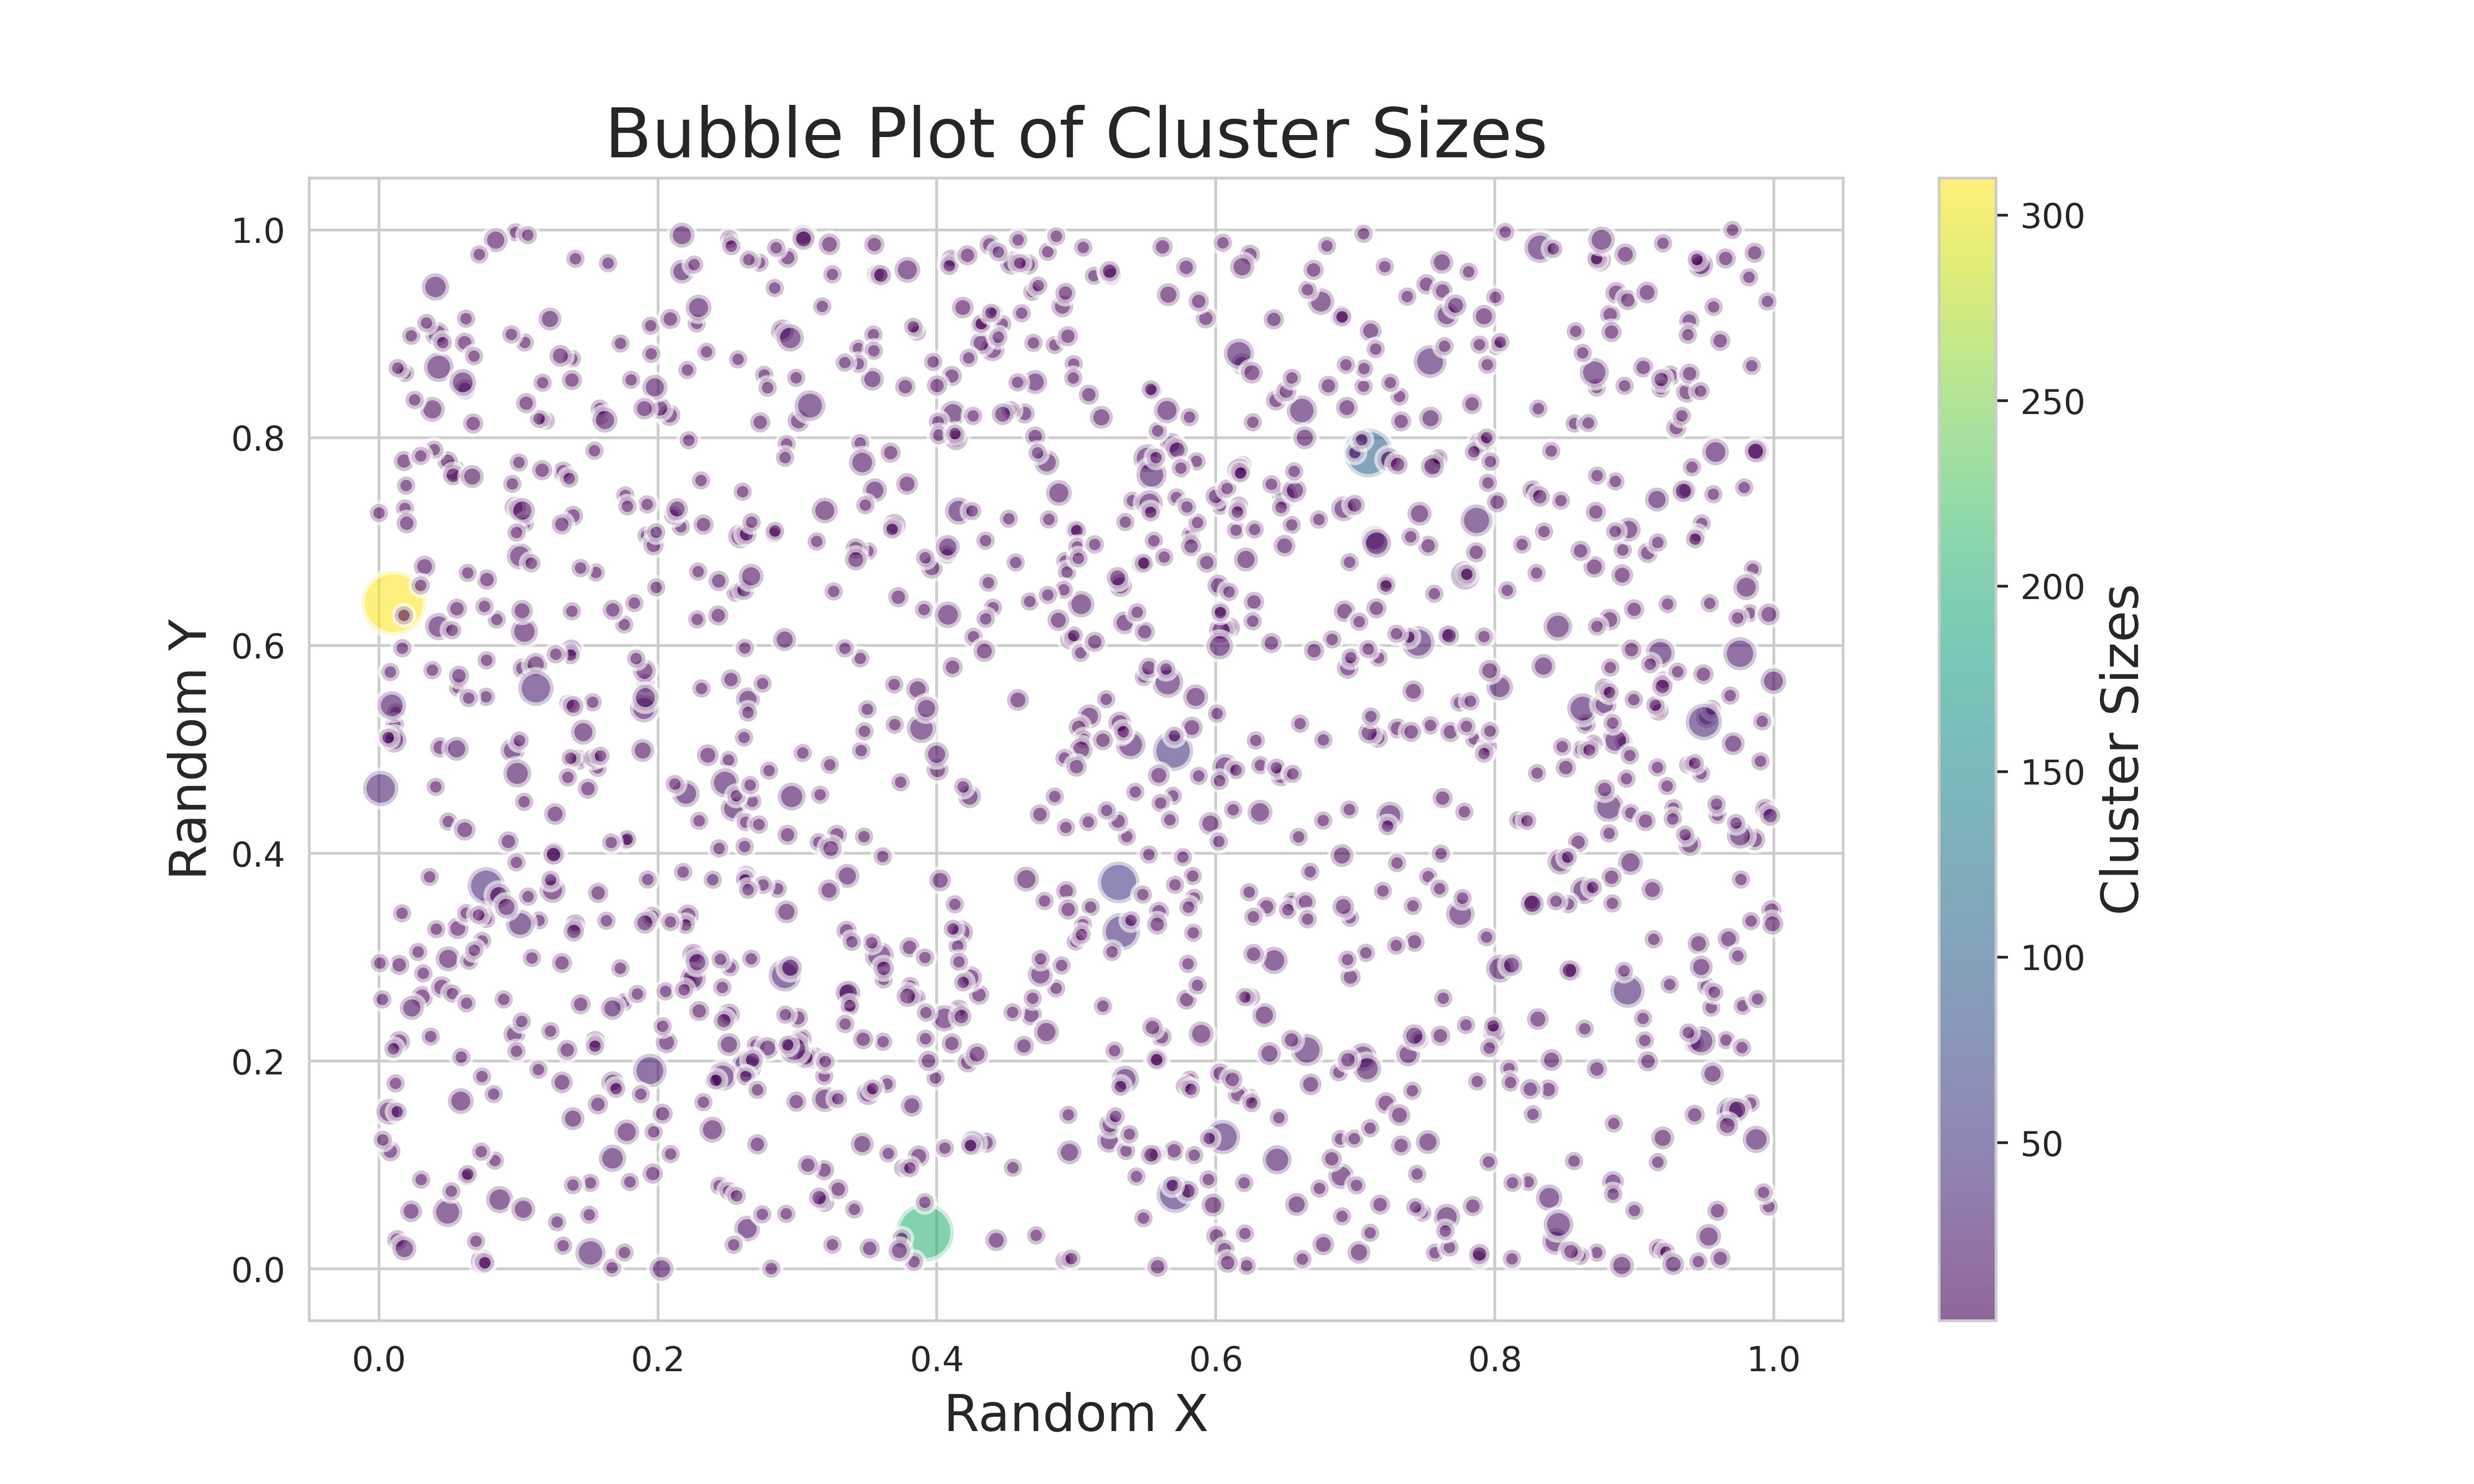

In [13]:
# and the bubble plot
display(Image(filename='min_cont_50_clusters_bubbles.png'))

In [ ]:
%%bash
## You may be interetsed in a given cluster of diseases e.g. the cluster including a disease of interest
cl_id=$(grep "congenital coloboma of iris" min_cont_50_clusters.tsv | cut -f1)
## One common question when you have a group of related disorders is to find out the commonly shared genes
## let's isolate this cluster and find what are the commonly shared genes
DBRetina query --index-prefix disgenetDBR --clusters-file min_cont_50_clusters.tsv --cluster-ids $cl_id -o sel_clust

In [16]:
%%bash
## The output has the shared genes sorted by frequency in the diseases of interest
## What are the most common shared genes in our cluster of interest?
head sel_clust_features_count_per_group.tsv

#command: DBRetina query --index-prefix disgenetDBR --clusters-file min_cont_50_clusters.tsv --cluster-ids 40 -o sel_clust
feature	supergroups_count	supergroups
actg1	14	macrostomia|highly arched eyebrow|ptosis|pointed chin|baraitser-winter syndrome 2|deafness, autosomal dominant 20|blepharoptosis|progressive sensorineural hearing impairment|fryns-aftimos syndrome|abnormality of the pinna|thin upper lip vermilion|congenital coloboma of iris|long philtrum|long palpebral fissure
pax6	10	morning glory syndrome|gillespie syndrome|optic nerve hypoplasia, bilateral|foveal hypoplasia 1|keratitis, hereditary|congenital coloboma of iris|o'donnell pappas syndrome|coloboma of optic disc|hypoplasia of the optic nerve|foveal hypoplasia (finding)
actb	6	qualitative abnormality of granulocyte|iris coloboma with ptosis, hypertelorism, and mental retardation|pigmented hairy epidermal nevus|fryns-aftimos syndrome|becker nevus syndrome|juvenile-onset dystonia
itpr1	3	spinocerebellar ataxia 29|gillespie s

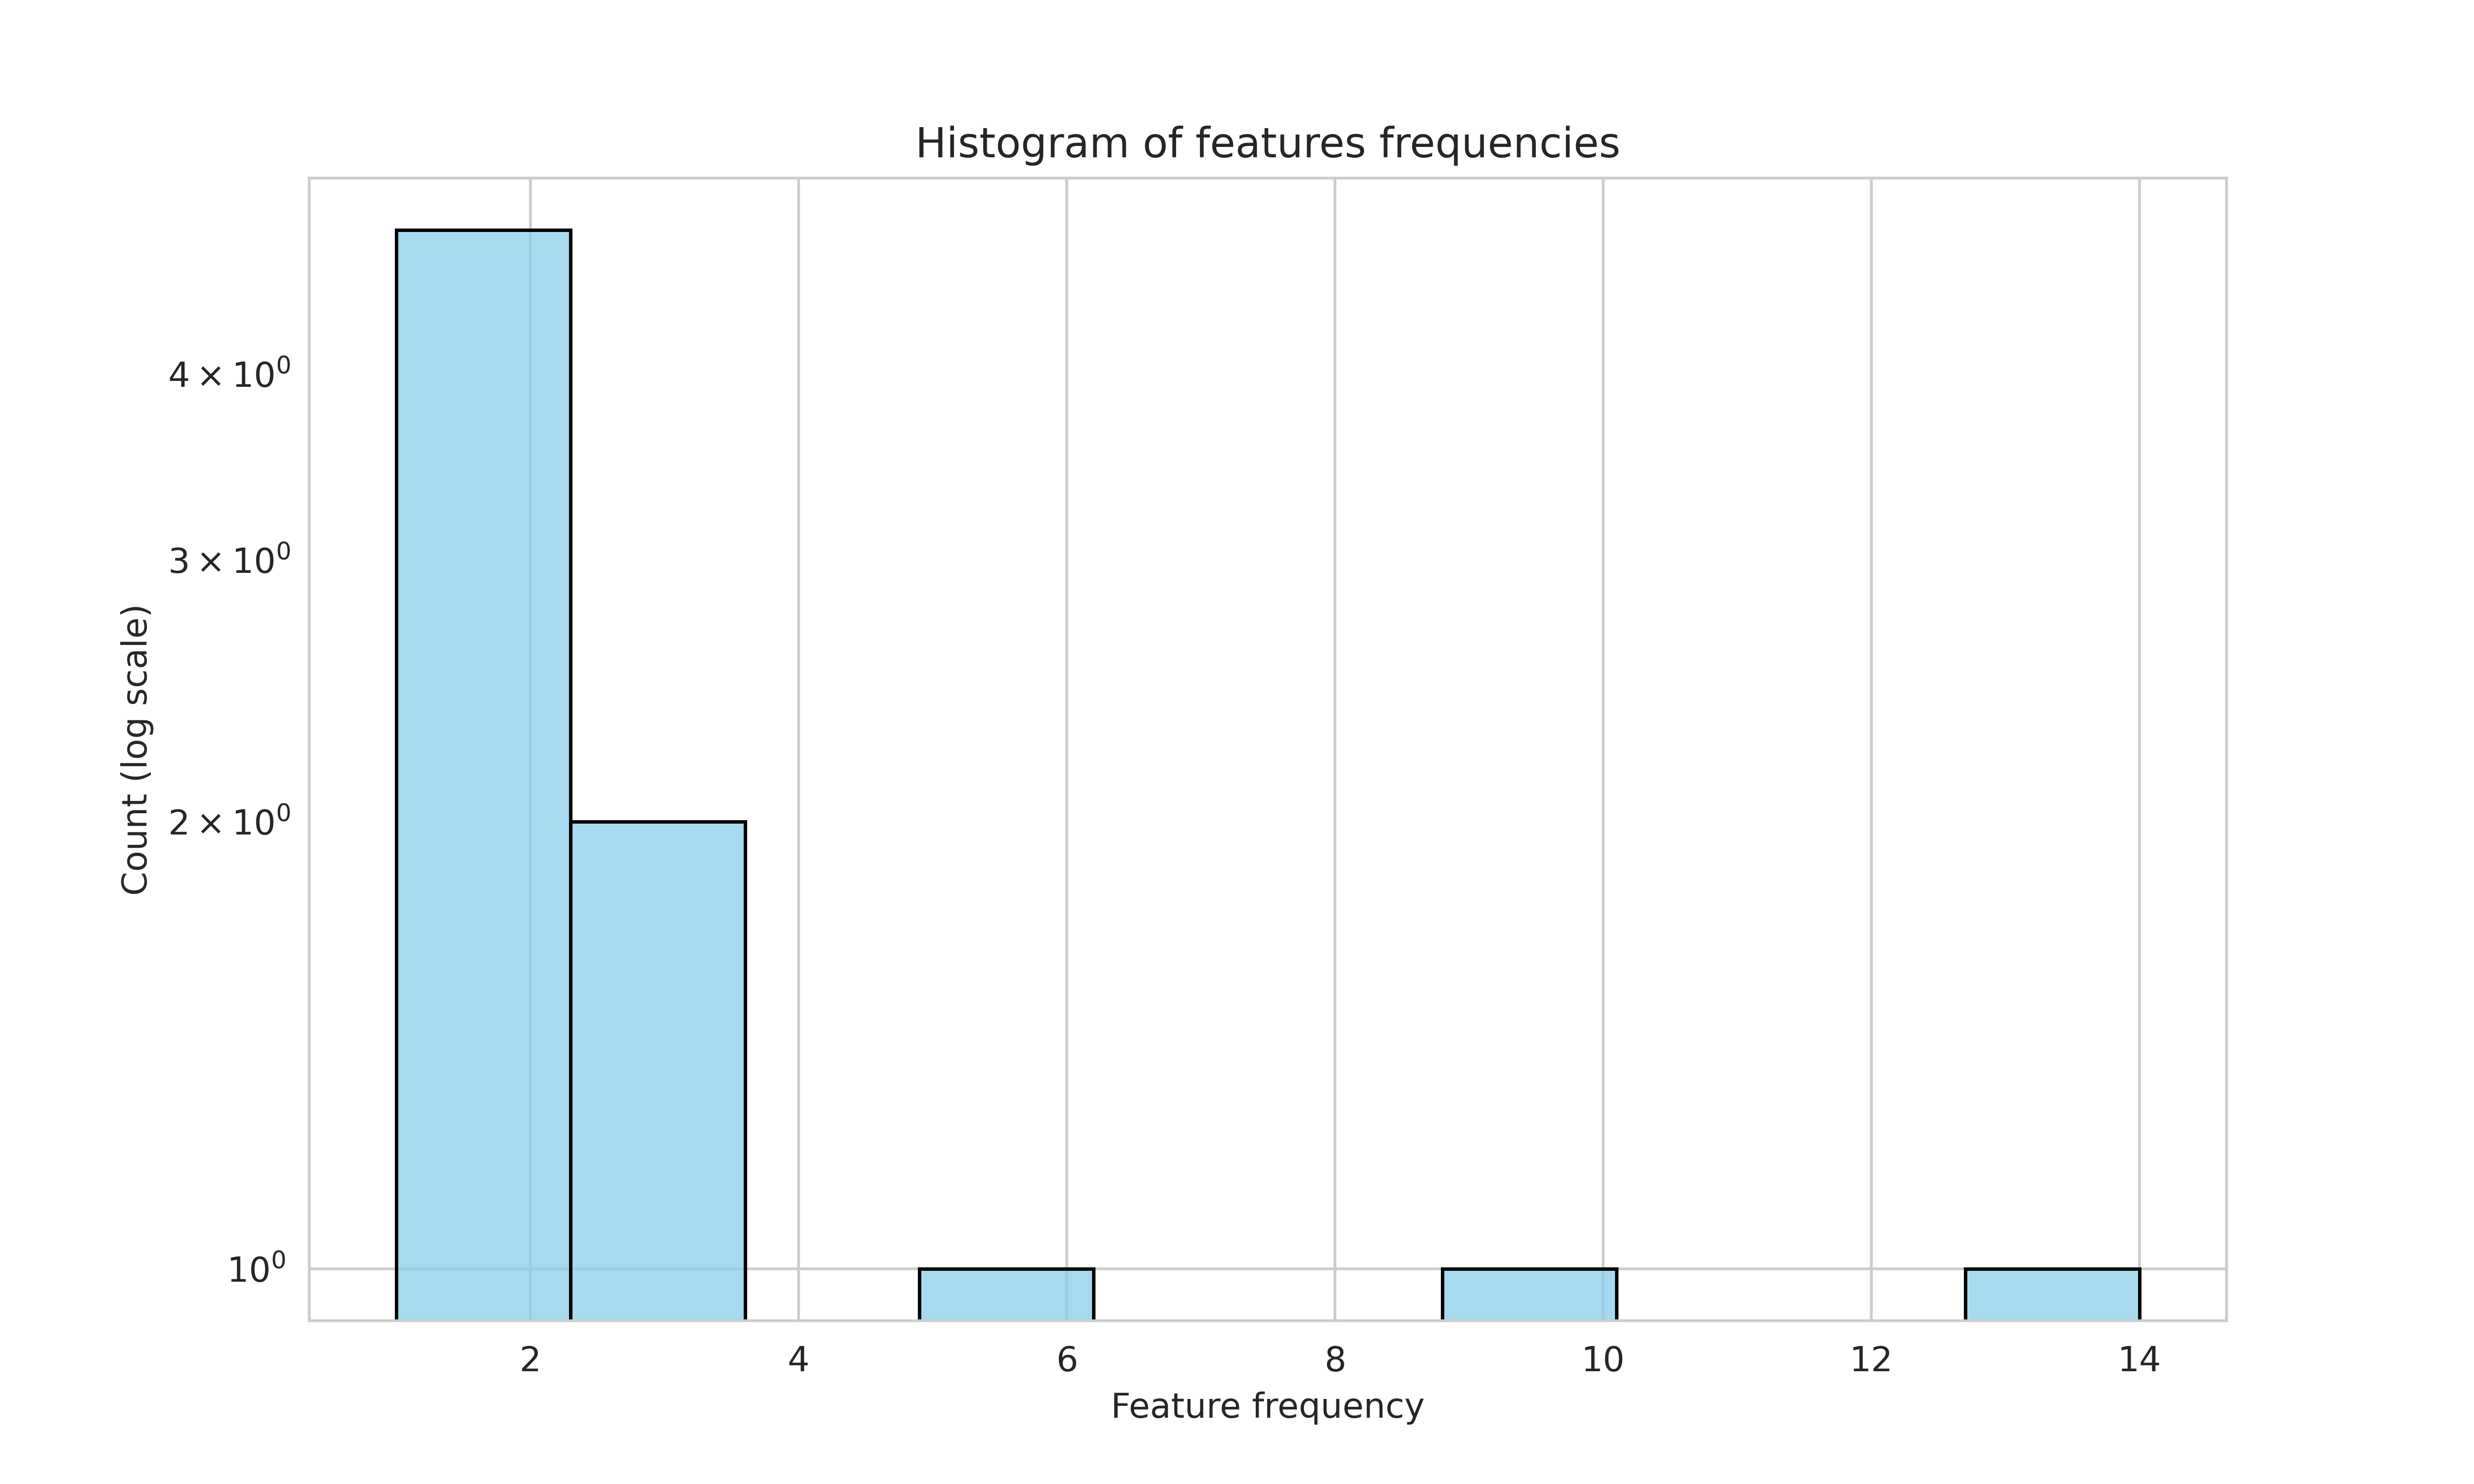

In [17]:
# The query function produces a histogram as well
display(Image(filename='sel_clust_features_count_per_group_histogram.png'))

In [18]:
%%bash
## Now, let's export the pairwise similarities of the diseases in the cluster of interest to be used in other visualizations (see documentation)
## First, you have to use "filter" to select a set of pairwise similarities to export. Note that the input pairwaise file and the filtering techqniue will impact this set  
## Here, we will start from the original "unfiltered" pairwaise file and filter a set of pairwise similarities between all the diseases in the selected cluster
cl_id=$(grep "congenital coloboma of iris" min_cont_50_clusters.tsv | cut -f1)
DBRetina filter --pairwise disgenetDBR_DBRetina_pairwise.tsv --clusters-file min_cont_50_clusters.tsv --cluster-ids $cl_id -o sel_clust
DBRetina export --pairwise sel_clust.tsv --dist-type min_cont --newick -o exp_clust

[INFO] Filtering the pairwise matrix on the NA column with a cutoff of 0.0 and groups file NA.
[INFO] Filtering by groups file .DBRetina.tmp.group
Please wait...
[SUCCESS] Done.
[INFO] serializing the distance matrix to exp_clust_distmat.pkl
[INFO] Writing distance matrix to exp_clust_distmat.tsv
[INFO] Writing clustermap plot to exp_clust_clustermap.png
[SUCCESS] Done.


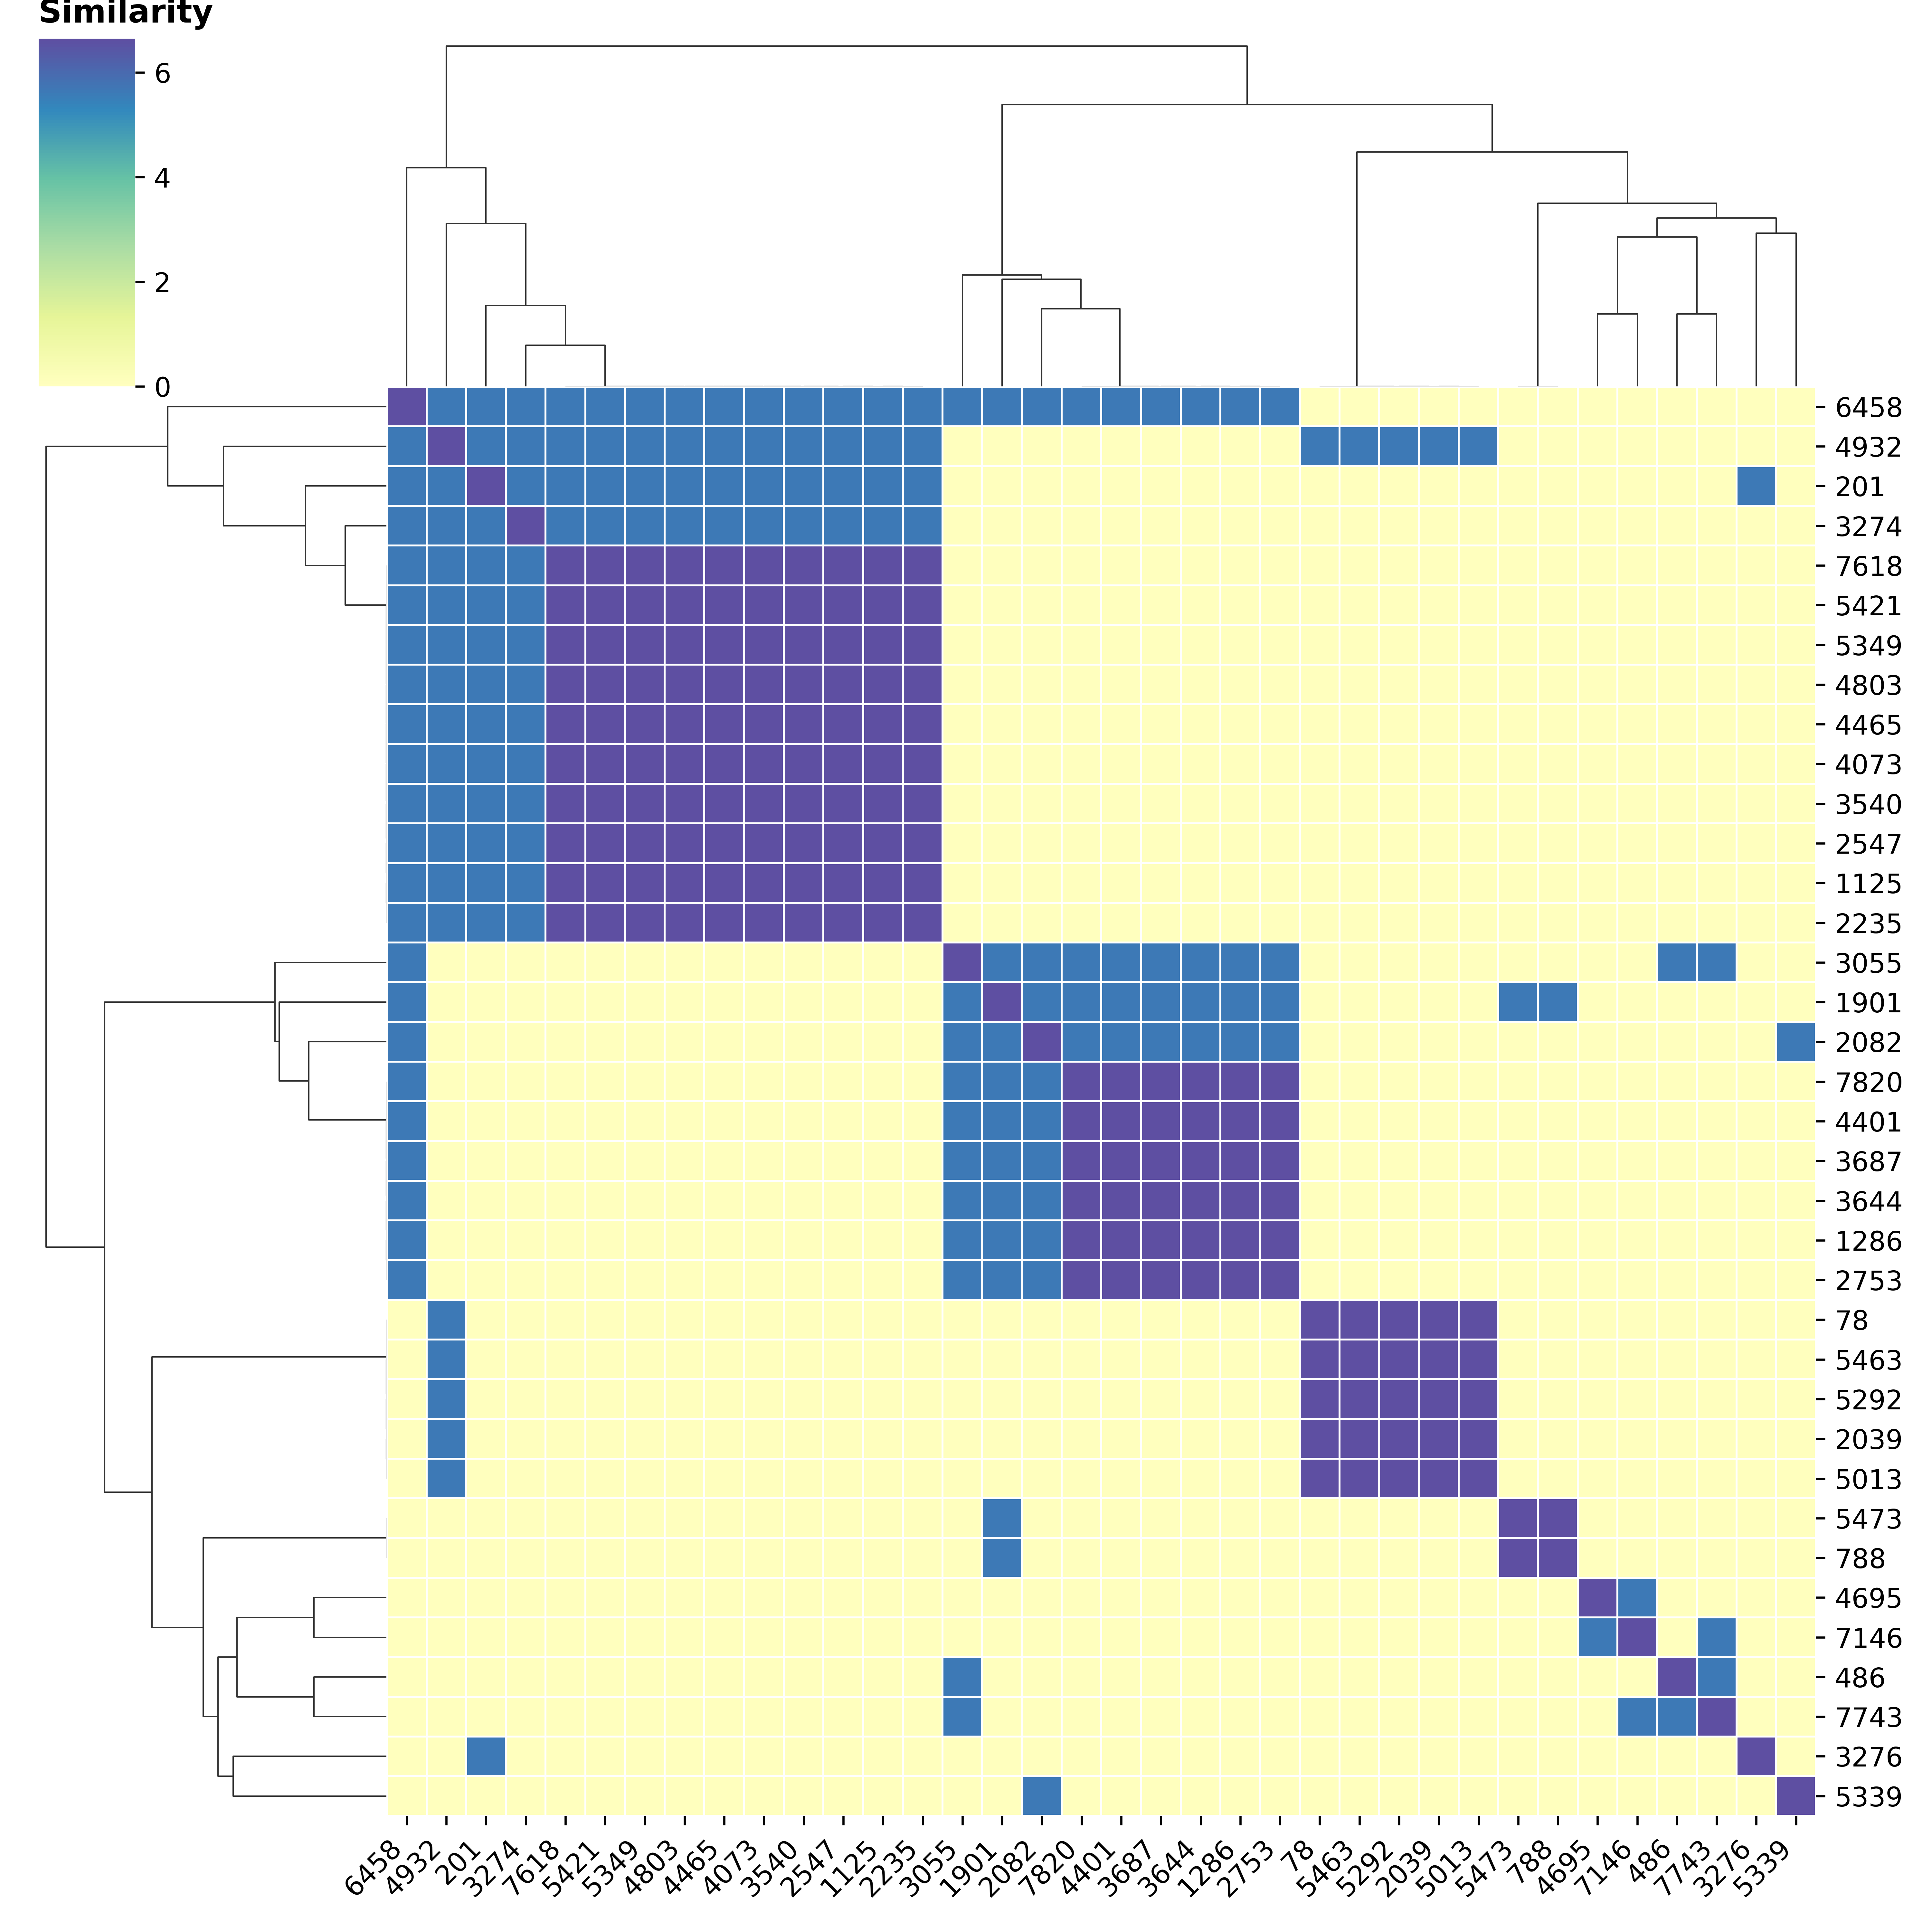

In [19]:
# The export function produces a heatmap
display(Image(filename='exp_clust_clustermap.png'))

In [1]:
%%bash
# Now, let us try another scenario where we already have a list of some how related disorders
# For simulation, we will create this list by selecting any Alzheimer disease in disgenet
grep -i "Alzheimer" disgenet.names | cut -f2 > Alzheimer_rel.lst
# Now, let's filter to select the related set of pairwise similarities but we will use the extended mode of filtering to include any similar diseases to out list
DBRetina filter --pairwise disgenetDBR_DBRetina_pairwise.tsv --dist-type jaccard --cutoff 10 -o jaccard_10 
DBRetina filter --pairwise jaccard_10.tsv --groups-file Alzheimer_rel.lst --dist-type max_cont --cutoff 25 --extend -o Alzheimer
DBRetina filter --pairwise disgenetDBR_DBRetina_pairwise.tsv --groups-file Alzheimer_extended_supergroups.txt -o disgenetDBR_Alzheimer


[WARNING] Output file jaccard_10.tsv already exists, overwriting ...
[INFO] Filtering the pairwise matrix on the jaccard column with a cutoff of 10.0 and groups file NA.
[INFO] Filtering the pairwise matrix on the jaccard column with a cutoff of 10.0.
[SUCCESS] Done.
[WARNING] Output file Alzheimer.tsv already exists, overwriting ...
[INFO] Filtering the pairwise matrix on the max_cont column with a cutoff of 25.0 and groups file /home/jovyan/Alzheimer_rel.lst.
[SUCCESS] Done.
[INFO] Filtering the pairwise matrix on the NA column with a cutoff of 0.0 and groups file /home/jovyan/Alzheimer_extended_supergroups.txt.
[INFO] Filtering by groups file /home/jovyan/Alzheimer_extended_supergroups.txt
Please wait...
[SUCCESS] Done.


In [2]:
# How many Alzheimer disease do we have?
!cat Alzheimer_rel.lst

ALZHEIMER DISEASE 18
ALZHEIMER DISEASE 2
ALZHEIMER DISEASE 4
ALZHEIMER DISEASE 9, SUSCEPTIBILITY TO
Alzheimer Disease, Early Onset
Alzheimer Disease, Familial, 3, with Spastic Paraparesis and Apraxia
Alzheimer disease, familial, type 3
Alzheimer Disease, Late Onset
Alzheimer's Disease
Familial Alzheimer Disease (FAD)


In [3]:
# How many disease similar to Alzheimer do we have?
!cat Alzheimer_extended_supergroups.txt

acne inversa, familial, 3
alzheimer disease 18
alzheimer disease 2
alzheimer disease 4
alzheimer disease, early onset
alzheimer disease, familial, 3, with spastic paraparesis and apraxia
alzheimer disease, familial, type 3
alzheimer disease, late onset
alzheimer's disease
amyloidosis
arteriosclerosis
behavioral variant of frontotemporal dementia
cardiomyopathy, dilated, 1u
cardiomyopathy, dilated, 1v
carotid artery diseases
carotid artery plaque
carotid atherosclerosis
carotid stenosis
cerebral amyloid angiopathy
cognition disorders
complex partial seizures
delirium
dementia
diabetes mellitus, experimental
dowling-degos disease
familial alzheimer disease (fad)
familial dementia
frontotemporal dementia
hepatolenticular degeneration
hidradenitis suppurativa, familial
hyperlipoproteinemia type iib
hyperlipoproteinemia type iii
hypothyroidism
impaired cognition
learning disabilities
lipoprotein glomerulopathy
memory disorders
memory loss
mental deterioration
mild cognitive disorder
multipl

In [4]:
%%bash
# update the IDs to be from 1 to n where n is the number of diseases in this small file
grep -v "^#" disgenetDBR_Alzheimer.tsv | tail -n+2 | awk 'BEGIN{FS="\t";OFS="\n";}{print $1 FS $3,$2 FS $4}' | sort -n | uniq | awk 'BEGIN{FS=OFS="\t";}{print $1,NR,$2}' > id.map
# Collect all pairwise distances of the diseases with high similarity to Alzheimer
grep -v "^#" Alzheimer.tsv | head -n1 > disgenetDBR_Alzheimer_newIds.tsv
awk 'BEGIN{FS=OFS="\t";}FNR==NR{a[$1]=$2;next;}{if(a[$1]&&a[$2]){$1=a[$1];$2=a[$2];print $0;}}' id.map disgenetDBR_Alzheimer.tsv >> disgenetDBR_Alzheimer_newIds.tsv


In [6]:
# enables the %%R magic
%load_ext rpy2.ipython

In [7]:
%%R 
if (!requireNamespace("RFLPtools", quietly = TRUE))
    install.packages("RFLPtools")
if (!requireNamespace("pheatmap", quietly = TRUE))
    install.packages("pheatmap")

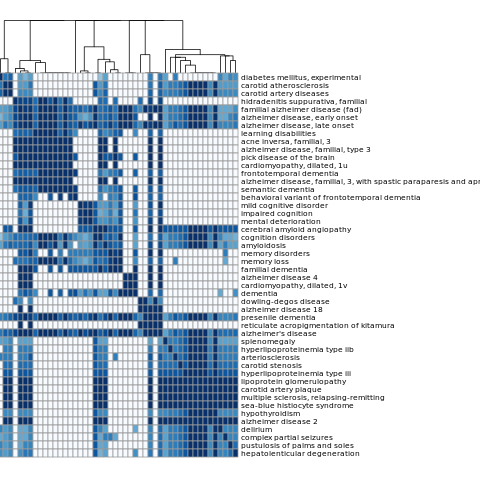

In [12]:
%%R
dbretina_rel=read.table(file="disgenetDBR_Alzheimer_newIds.tsv" ,skip=0, header=TRUE, sep = "\t", quote = "", dec = ".");
dbretina_nodes=read.table(file="id.map", header=FALSE, sep = "\t", quote = "");

target="max_containment"
size=dim(dbretina_nodes)[1]
dbret_count_matrix = matrix(0, nrow = size, ncol = size)
for (i in 1:dim(dbretina_rel)[1]){
  dbret_count_matrix[dbretina_rel$group_1_ID[i],dbretina_rel$group_2_ID[i]]=log2(dbretina_rel[[target]][i])
  dbret_count_matrix[dbretina_rel$group_2_ID[i],dbretina_rel$group_1_ID[i]]=log2(dbretina_rel[[target]][i])
}


## transform the similarity matrix into distance object (measure the dissimilarity)

library(RFLPtools)
dbret_count_dist = sim2dist(dbret_count_matrix, log2(100))
## Transform the dist object back into into matrix
dbret_count_matrix = as.matrix(dbret_count_dist)

rownames(dbret_count_matrix) <- dbretina_nodes$V3
colnames(dbret_count_matrix) <- NULL

library(pheatmap)
#library(repr)

colors <- colorRampPalette( rev(brewer.pal(9, "Blues")) )(255) ## specify a blue color palette for painting
#options(repr.plot.width = 4, repr.plot.height = 2)
#jpeg("outfig")
pheatmap(dbret_count_matrix,
         clustering_distance_rows = dbret_count_dist,
         clustering_distance_cols = dbret_count_dist,
         col = colors, cellwidth=5,cellheight=8, fontsize_row=7.5,fontsize_col=0)
#dev.off()